In [1]:
import os
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
from itertools import cycle
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import torchvision.transforms as transforms
from torchvision import models
from torchvision.datasets import ImageFolder
# ignore the warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
data_dir = "D:\\cassava dataset-2"

In [3]:
# Custom dataset loader for image data
class CustomImageDataset(Dataset):
    def __init__(self, filepaths, labels, transform=None):
        self.filepaths = filepaths
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.filepaths)
    
    def __getitem__(self, idx):
        image = cv2.imread(self.filepaths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Load data

def loading_the_data(data_dir):
    filepaths = []
    labels = []

    folds = os.listdir(data_dir)

    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            
            filepaths.append(fpath)
            labels.append(fold)

    return pd.DataFrame({"filepaths": filepaths, "labels": labels})

# data_dir = "F:\\Ml files\\XAI\\Grape\\Combined (D4)"
df = loading_the_data(data_dir)

                  Class  Number of Images
0        Cassava Blight              1000
1  Cassava Healthy leaf              1000
2        Cassava Mosaic              1000


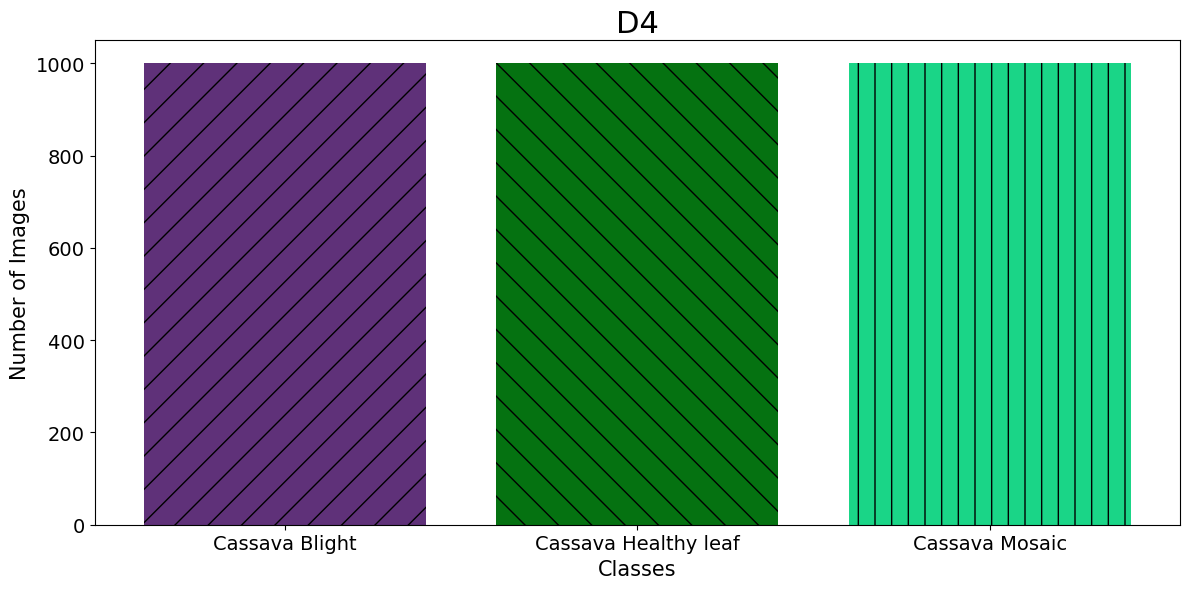

In [4]:
import random
plt.style.use('default')

# Get the list of categories (subfolder names)
categories = [folder for folder in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, folder))]

# Count the number of images in each category
image_counts = []
for category in categories:
    category_path = os.path.join(data_dir, category)
    image_files = [file for file in os.listdir(category_path) if file.lower().endswith(('png', 'jpg', 'jpeg', 'bmp', 'tiff'))]
    image_counts.append(len(image_files))

# Create a dataframe to show the number of images per class
data = pd.DataFrame({"Class": categories, "Number of Images": image_counts})
print(data)


# Create a bar chart to visualize the number of images in each category
plt.figure(figsize=(12, 6))
patterns = ["/", "\\", "|", "-", "+", "x", "o", "*"]  # Define patterns for bars
colors = ["#" + ''.join(random.choices('0123456789ABCDEF', k=6)) for _ in categories]  # Generate unique colors
bars = plt.bar(categories, image_counts, color=colors)
for bar, pattern in zip(bars, patterns):
    bar.set_hatch(pattern)

plt.title("D4", fontsize=22)
plt.xlabel("Classes", fontsize=15)
plt.ylabel("Number of Images", fontsize=15)
plt.xticks(rotation=0, fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()


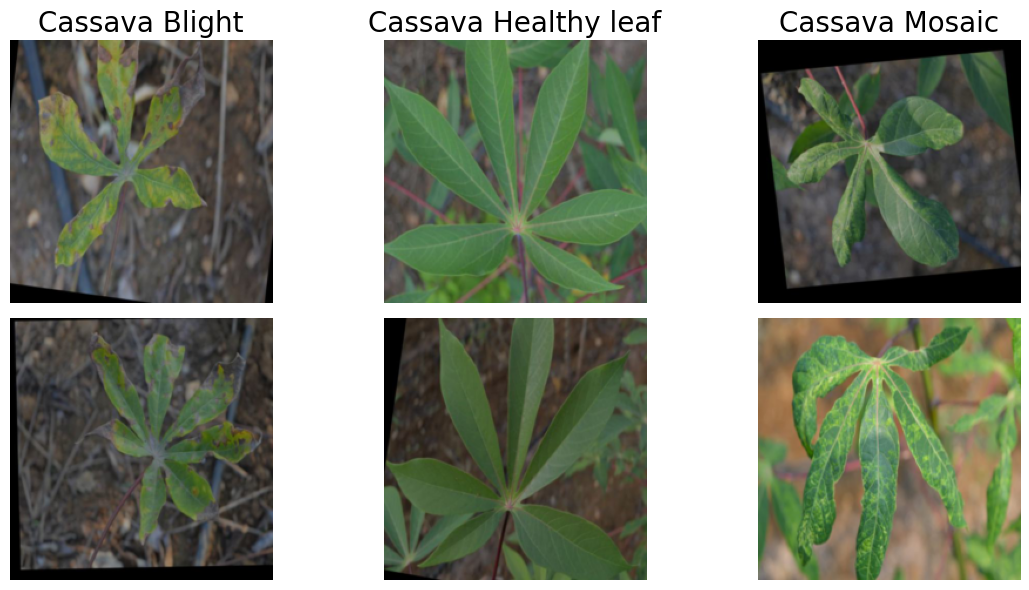

In [5]:
from PIL import Image

# Define a transform to resize images and convert them to tensors
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 512x512 for uniformity
    transforms.ToTensor()
])

# Number of rows and columns
rows, cols = 2, 3

# Ensure categories list contains at least `cols` categories
if len(categories) < cols:
    raise ValueError("Not enough categories to display.")

# Initialize a figure for visualization
plt.figure(figsize=(12, 6))  # Adjusted figure size for better clarity with 2 rows and 5 columns

# Iterate twice to create two rows with different images from the same categories
for row in range(rows):
    for col, category in enumerate(categories[:cols]):  # Use the first `cols` categories
        # Get the path of the category folder
        category_path = os.path.join(data_dir, category)

        # Get the list of image files in the category folder
        image_files = [file for file in os.listdir(category_path) if file.lower().endswith(('png', 'jpg', 'jpeg', 'bmp', 'tiff'))]

        # Ensure there is at least one image in the category
        if not image_files:
            print(f"No images found in category: {category}")
            continue

        # Randomly select an image from the category
        image_path = os.path.join(category_path, random.choice(image_files))
        image = Image.open(image_path).convert("RGB")

        # Apply the transform
        image = transform(image)

        # Convert the tensor back to a PIL image for visualization
        image = transforms.ToPILImage()(image)

        # Add the image to the plot
        plt.subplot(rows, cols, row * cols + col + 1)
        plt.imshow(image)
        
        # Set title only for the first row
        if row == 0:
            plt.title(category, fontsize=20)
        
        plt.axis('off')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [6]:
# Data transformation
data_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [7]:
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['labels'], random_state=42)  # 80% train, 20% temp
val_df, test_df = train_test_split(temp_df, test_size=0.75, stratify=temp_df['labels'], random_state=42)  # 75% of temp (15% of total) for test


In [8]:
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(2400, 2)
(150, 2)
(450, 2)


In [9]:
import pandas as pd

# Assuming train_df, val_df, and test_df have a 'labels' column
train_counts = train_df['labels'].value_counts()
val_counts = val_df['labels'].value_counts()
test_counts = test_df['labels'].value_counts()

# Combine into a single DataFrame
class_counts = pd.DataFrame({
    'Training': train_counts,
    'Validation': val_counts,
    'Testing': test_counts
}).fillna(0).astype(int)  # Fill NaN with 0 and convert to integer

# Add a column for total counts (optional)
class_counts['Total'] = class_counts.sum(axis=1)

# Display the table
print(class_counts)


                      Training  Validation  Testing  Total
labels                                                    
Cassava Blight             800          50      150   1000
Cassava Healthy leaf       800          50      150   1000
Cassava Mosaic             800          50      150   1000


In [10]:
# Encoding labels
label_mapping = {label: idx for idx, label in enumerate(df['labels'].unique())}
train_labels = train_df['labels'].map(label_mapping).values
val_labels = val_df['labels'].map(label_mapping).values
test_labels = test_df['labels'].map(label_mapping).values

# Creating datasets and loaders
train_dataset = CustomImageDataset(train_df['filepaths'].values, train_labels, transform=data_transform)
val_dataset = CustomImageDataset(val_df['filepaths'].values, val_labels, transform=data_transform)
test_dataset = CustomImageDataset(test_df['filepaths'].values, test_labels, transform=data_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0, pin_memory=True)

In [11]:
# Model setup
if not torch.cuda.is_available():
    raise RuntimeError('CUDA device is not available. Please ensure a GPU is available to train the model.')
device = torch.device('cuda')

In [12]:
import timm

def load_model(model_name, num_classes, pretrained=False):
    model = timm.create_model(model_name, pretrained=pretrained)
    
    # Modify the classifier part of the model to match the number of classes
    model.classifier = nn.Sequential(
        nn.Linear(model.classifier.in_features, 512),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512, num_classes),  # num_classes should be the number of classes in your dataset
        nn.LogSoftmax(dim=1)
    )

    return model

# Number of classes (adjust to your problem)
num_classes = len(label_mapping)  # Replace label_mapping with the actual class labels

# Load EfficientNetV2-M without pre-trained weights
model = load_model("efficientnetv2_m", num_classes, pretrained=False)

model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
# Define Learning Rate Scheduler (e.g., Cosine Annealing)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)

Epoch 1/20
----------


Validation Loss: 0.5962, Validation Accuracy: 0.7533
Epoch 1/20, Loss: 0.8453, Accuracy: 0.5792
Epoch 2/20
----------


Validation Loss: 0.4989, Validation Accuracy: 0.8267
Epoch 2/20, Loss: 0.6382, Accuracy: 0.7300
Epoch 3/20
----------


Validation Loss: 0.2685, Validation Accuracy: 0.9000
Epoch 3/20, Loss: 0.5349, Accuracy: 0.7854
Epoch 4/20
----------


Validation Loss: 0.2518, Validation Accuracy: 0.9067
Epoch 4/20, Loss: 0.3354, Accuracy: 0.8762
Epoch 5/20
----------


Validation Loss: 0.1722, Validation Accuracy: 0.9267
Epoch 5/20, Loss: 0.2231, Accuracy: 0.9192
Epoch 6/20
----------


Validation Loss: 0.0609, Validation Accuracy: 0.9733
Epoch 6/20, Loss: 0.1161, Accuracy: 0.9600
Epoch 7/20
----------


Validation Loss: 0.0914, Validation Accuracy: 0.9600
Epoch 7/20, Loss: 0.0611, Accuracy: 0.9812
Patience Counter: 1/5
Epoch 8/20
----------


Validation Loss: 0.0433, Validation Accuracy: 0.9800
Epoch 8/20, Loss: 0.0505, Accuracy: 0.9854
Epoch 9/20
----------


Validation Loss: 0.0175, Validation Accuracy: 1.0000
Epoch 9/20, Loss: 0.0255, Accuracy: 0.9912
Epoch 10/20
----------


Validation Loss: 0.0220, Validation Accuracy: 1.0000
Epoch 10/20, Loss: 0.0418, Accuracy: 0.9912
Patience Counter: 1/5
Epoch 11/20
----------


Validation Loss: 0.0151, Validation Accuracy: 1.0000
Epoch 11/20, Loss: 0.0545, Accuracy: 0.9908
Epoch 12/20
----------


Validation Loss: 0.0105, Validation Accuracy: 1.0000
Epoch 12/20, Loss: 0.0281, Accuracy: 0.9938
Epoch 13/20
----------


Validation Loss: 0.0128, Validation Accuracy: 1.0000
Epoch 13/20, Loss: 0.0226, Accuracy: 0.9942
Patience Counter: 1/5
Epoch 14/20
----------


Validation Loss: 0.0534, Validation Accuracy: 0.9733
Epoch 14/20, Loss: 0.0182, Accuracy: 0.9950
Patience Counter: 2/5
Epoch 15/20
----------


Validation Loss: 0.0513, Validation Accuracy: 0.9867
Epoch 15/20, Loss: 0.1243, Accuracy: 0.9604
Patience Counter: 3/5
Epoch 16/20
----------


Validation Loss: 0.0602, Validation Accuracy: 0.9867
Epoch 16/20, Loss: 0.1618, Accuracy: 0.9433
Patience Counter: 4/5
Epoch 17/20
----------


Validation Loss: 0.0950, Validation Accuracy: 0.9800
Epoch 17/20, Loss: 0.1205, Accuracy: 0.9592
Patience Counter: 5/5
Early stopping triggered at epoch 17 (Patience exceeded).


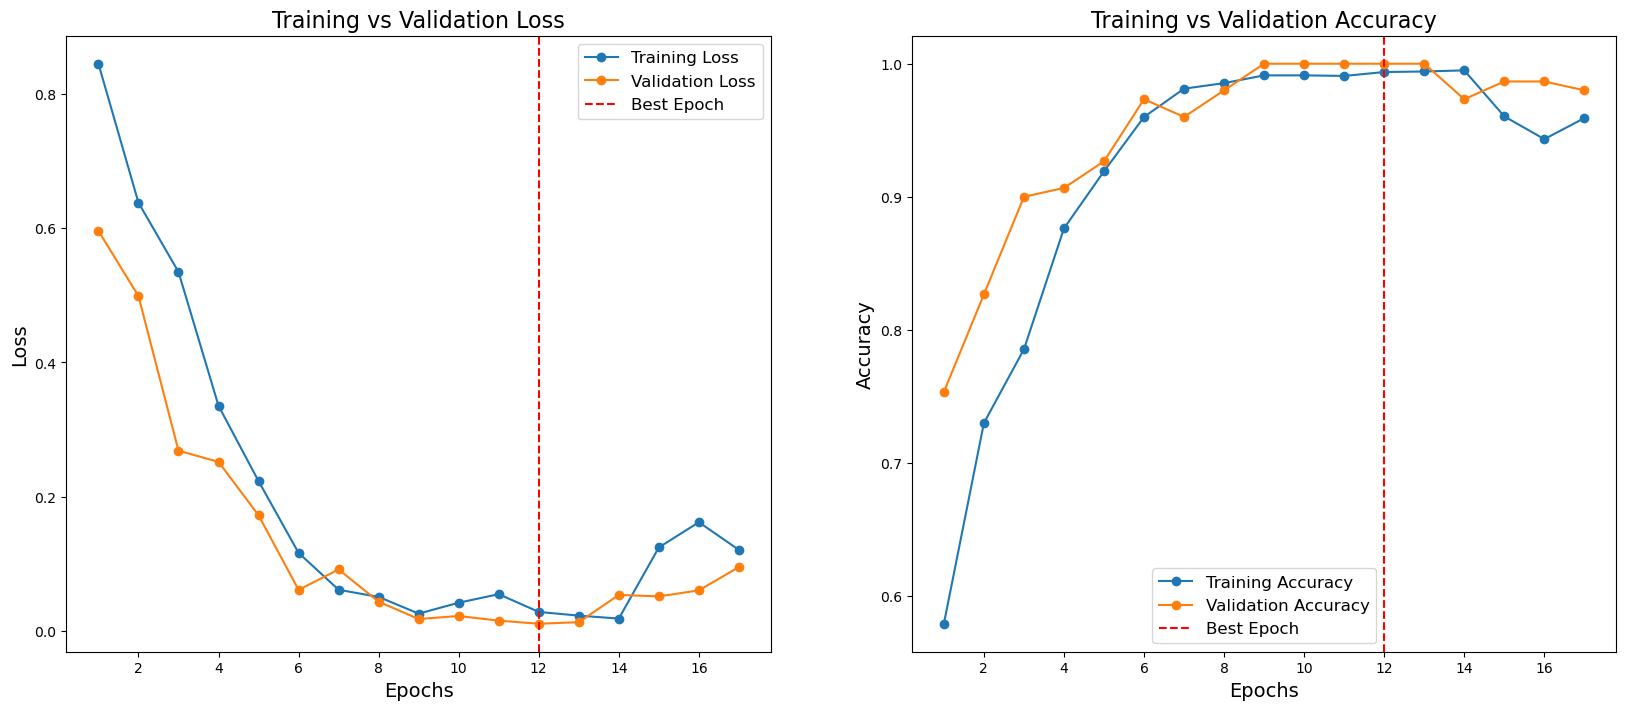


Training Report:
-----------------
Total epochs run: 17
Final Training Loss: 0.1205
Final Training Accuracy: 0.9592

Validation Report:
-----------------
Best Validation Loss: 0.0105 at epoch 12
Final Validation Loss: 0.0950
Final Validation Accuracy: 0.9800


In [13]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20, patience=5):
    model.train()
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    best_val_loss = float('inf')
    best_val_accuracy = 0.0
    patience_counter = 0
    best_epoch = 0
    
    for epoch in range(num_epochs):
        model.train()
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in tqdm(train_loader, desc='Training', leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_loss = val_running_loss / len(val_loader.dataset)
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
        print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')
        
        # Early stopping check based on validation loss or accuracy
        if val_loss < best_val_loss or val_acc > best_val_accuracy:
            # Reset the patience counter if there is an improvement
            patience_counter = 0
            best_val_loss = val_loss
            best_val_accuracy = val_acc
            best_epoch = epoch + 1
        else:
            patience_counter += 1
            print(f"Patience Counter: {patience_counter}/{patience}")
        
        # If the patience counter reaches the patience limit, stop training
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1} (Patience exceeded).")
            break
        
        # Step the scheduler at the end of each epoch
        scheduler.step()
    
    total_epochs_run = epoch + 1

    # Plot learning curves with early stopping marker at the best epoch
    epochs_range = range(1, total_epochs_run + 1)
    plt.figure(figsize=(20, 8))
    
    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, marker='o', label='Training Loss')
    plt.plot(epochs_range, val_losses, marker='o', label='Validation Loss')
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.title('Training vs Validation Loss', fontsize=16)
    plt.axvline(x=best_epoch, color='red', linestyle='--', label='Best Epoch')
    plt.legend(fontsize=12)
    
    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accuracies, marker='o', label='Training Accuracy')
    plt.plot(epochs_range, val_accuracies, marker='o', label='Validation Accuracy')
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.title('Training vs Validation Accuracy', fontsize=16)
    plt.axvline(x=best_epoch, color='red', linestyle='--', label='Best Epoch')
    plt.legend(fontsize=12)
    plt.show()

    # Print training and validation reports
    print("\nTraining Report:")
    print("-----------------")
    print(f"Total epochs run: {total_epochs_run}")
    print(f"Final Training Loss: {train_losses[-1]:.4f}")
    print(f"Final Training Accuracy: {train_accuracies[-1]:.4f}")
    
    print("\nValidation Report:")
    print("-----------------")
    print(f"Best Validation Loss: {best_val_loss:.4f} at epoch {best_epoch}")
    print(f"Final Validation Loss: {val_losses[-1]:.4f}")
    print(f"Final Validation Accuracy: {val_accuracies[-1]:.4f}")

# Assuming you have already defined model, train_loader, val_loader, criterion, optimizer

train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20, patience=5)

In [14]:
def evaluate_model(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    all_probs = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            
            # Convert LogSoftmax to probabilities
            probs = torch.exp(outputs)  # Exponentiate to get probabilities
            
            # Get the predicted class (highest probability)
            _, predicted = torch.max(outputs, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Collect all labels, predictions, and probabilities for further analysis
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    accuracy = correct / total
    print(f'Accuracy: {accuracy:.4f}')
    print(classification_report(all_labels, all_preds))
    
    # ------------------------------
    # Plot Confusion Matrix
    # ------------------------------
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys(),
                cbar_kws={'shrink': 0.8})
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16, rotation=0)
    plt.xlabel('Predicted', fontsize=18)
    plt.ylabel('True', fontsize=18)
    plt.title('Confusion Matrix', fontsize=20)
    plt.show()

    # ------------------------------
    # Plot ROC AUC curves
    # ------------------------------
    n_classes = len(label_mapping)
    y_test_bin = label_binarize(all_labels, classes=range(n_classes))

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], np.array(all_probs)[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    plt.figure(figsize=(12, 8))
    colors = cycle(['blue', 'red', 'green', 'orange'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of class {i} (area = {roc_auc[i]:0.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([-0.03, 1.1])
    plt.ylim([-0.02, 1.1])
    plt.xlabel('False Positive Rate', fontsize=18)
    plt.ylabel('True Positive Rate', fontsize=18)
    plt.title('ROC AUC Curve for Multiclass Classification', fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(fontsize=16)
    plt.show()

    # ------------------------------
    # Plot Precision-Recall curves
    # ------------------------------
    precision = dict()
    recall = dict()
    average_precision = dict()
    
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], np.array(all_probs)[:, i])
        average_precision[i] = average_precision_score(y_test_bin[:, i], np.array(all_probs)[:, i])
    
    plt.figure(figsize=(12, 8))
    for i, color in zip(range(n_classes), cycle(['blue', 'red', 'green', 'orange'])):
        plt.plot(recall[i], precision[i], color=color, lw=2,
                 label=f'PR curve of class {i} (AP = {average_precision[i]:0.2f})')
    plt.xlabel('Recall', fontsize=18)
    plt.ylabel('Precision', fontsize=18)
    plt.title('Precision-Recall Curve for Multiclass Classification', fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(fontsize=16)
    plt.show()

Accuracy: 0.9578
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       150
           1       0.98      0.91      0.94       150
           2       0.97      0.99      0.98       150

    accuracy                           0.96       450
   macro avg       0.96      0.96      0.96       450
weighted avg       0.96      0.96      0.96       450



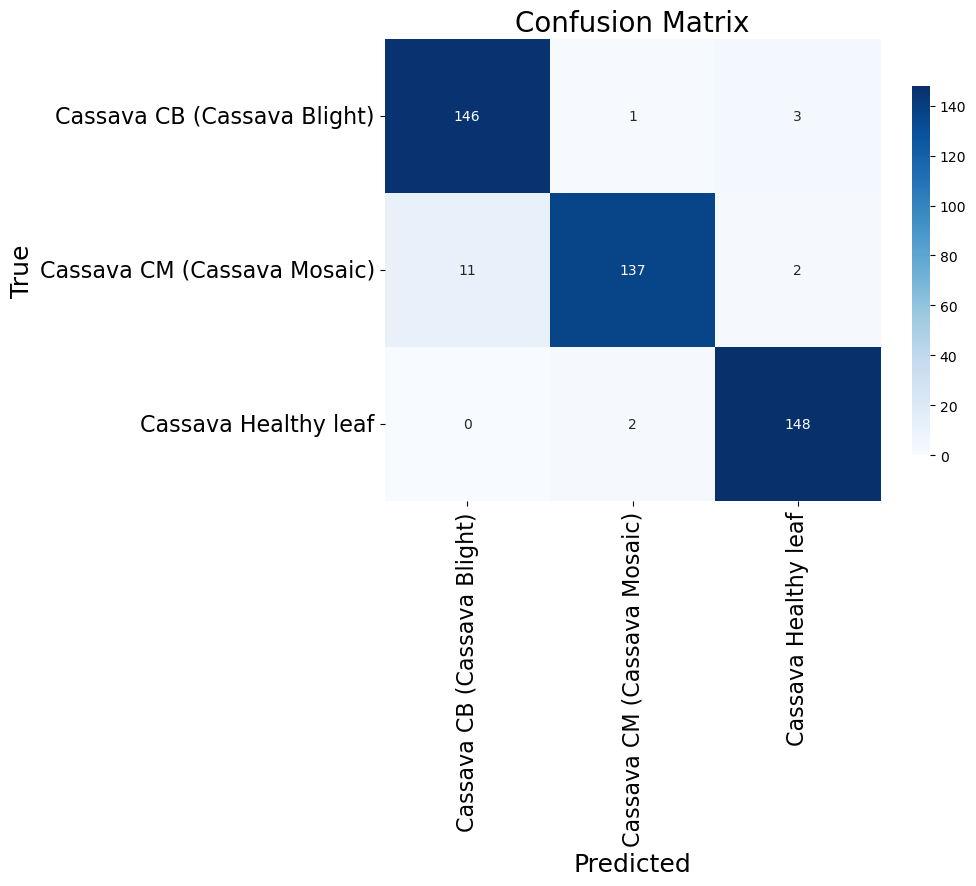

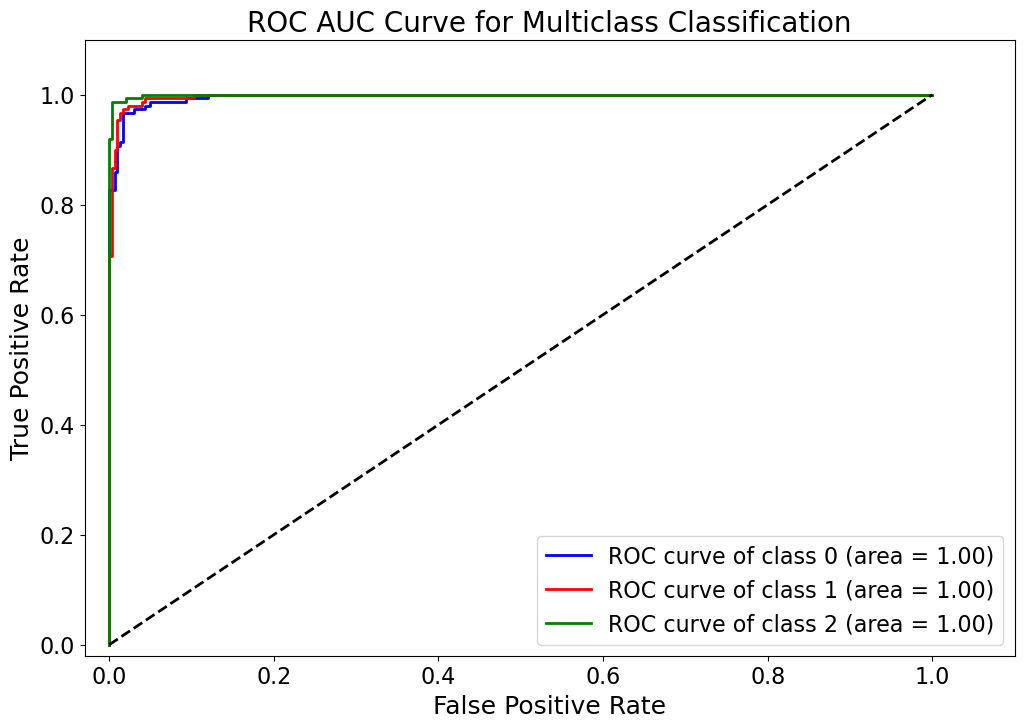

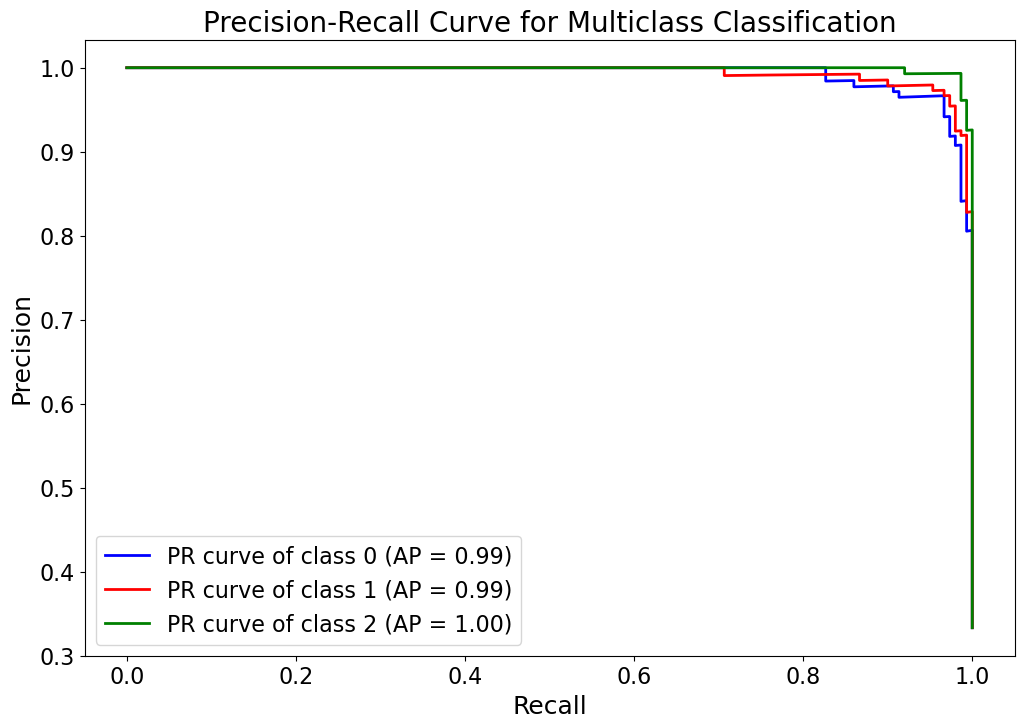

In [15]:
evaluate_model(model, test_loader)

In [22]:
torch.save(model.state_dict(), "BoneEfficientNetV2-M.pth")

In [14]:
import timm

num_classes = len(label_mapping)

model_name = 'lcnet_100'

# Create the model using timm with pretrained weights and adjusted classifier
model = timm.create_model(model_name, pretrained=True, num_classes=num_classes, drop_rate=0.4)

model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)

In [15]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20, patience=5):
    model.train()
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    best_val_loss = float('inf')
    best_val_accuracy = 0.0
    patience_counter = 0
    best_epoch = 0
    
    for epoch in range(num_epochs):
        model.train()
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in tqdm(train_loader, desc='Training', leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_loss = val_running_loss / len(val_loader.dataset)
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
        print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')
        
        # Early stopping check based on validation loss or accuracy
        if val_loss < best_val_loss and val_acc > best_val_accuracy:
            # Reset the patience counter if there is an improvement
            patience_counter = 0
            best_val_loss = val_loss
            best_val_accuracy = val_acc
            best_epoch = epoch + 1
        else:
            patience_counter += 1
            print(f"Patience Counter: {patience_counter}/{patience}")
        
        # If the patience counter reaches the patience limit, stop training
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1} (Patience exceeded).")
            break
        
        # Step the scheduler at the end of each epoch
        scheduler.step()
    
    total_epochs_run = epoch + 1

    # Plot learning curves with early stopping marker at the best epoch
    epochs_range = range(1, total_epochs_run + 1)
    plt.figure(figsize=(20, 8))
    
    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, marker='o', label='Training Loss')
    plt.plot(epochs_range, val_losses, marker='o', label='Validation Loss')
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.title('Training vs Validation Loss', fontsize=16)
    plt.axvline(x=best_epoch, color='red', linestyle='--', label='Best Epoch')
    plt.legend(fontsize=12)
    
    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accuracies, marker='o', label='Training Accuracy')
    plt.plot(epochs_range, val_accuracies, marker='o', label='Validation Accuracy')
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.title('Training vs Validation Accuracy', fontsize=16)
    plt.axvline(x=best_epoch, color='red', linestyle='--', label='Best Epoch')
    plt.legend(fontsize=12)
    plt.show()

    # Print training and validation reports
    print("\nTraining Report:")
    print("-----------------")
    print(f"Total epochs run: {total_epochs_run}")
    print(f"Final Training Loss: {train_losses[-1]:.4f}")
    print(f"Final Training Accuracy: {train_accuracies[-1]:.4f}")
    
    print("\nValidation Report:")
    print("-----------------")
    print(f"Best Validation Loss: {best_val_loss:.4f} at epoch {best_epoch}")
    print(f"Final Validation Loss: {val_losses[-1]:.4f}")
    print(f"Final Validation Accuracy: {val_accuracies[-1]:.4f}")

# Assuming you have already defined model, train_loader, val_loader, criterion, optimizer
# Define Learning Rate Scheduler (e.g., Cosine Annealing)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)

train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20, patience=5)


Epoch 1/20
----------


KeyboardInterrupt: 

In [18]:
def evaluate_model(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    all_probs = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            
            # Convert LogSoftmax to probabilities
            probs = torch.exp(outputs)  # Exponentiate to get probabilities
            
            # Get the predicted class (highest probability)
            _, predicted = torch.max(outputs, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Collect all labels, predictions, and probabilities for further analysis
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    accuracy = correct / total
    print(f'Accuracy: {accuracy:.4f}')
    print(classification_report(all_labels, all_preds))
    
    # ------------------------------
    # Plot Confusion Matrix
    # ------------------------------
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys(),
                cbar_kws={'shrink': 0.8})
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16, rotation=0)
    plt.xlabel('Predicted', fontsize=18)
    plt.ylabel('True', fontsize=18)
    plt.title('Confusion Matrix', fontsize=20)
    plt.show()

    # ------------------------------
    # Plot ROC AUC curves
    # ------------------------------
    n_classes = len(label_mapping)
    y_test_bin = label_binarize(all_labels, classes=range(n_classes))

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], np.array(all_probs)[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    plt.figure(figsize=(12, 8))
    colors = cycle(['blue', 'red', 'green', 'orange'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of class {i} (area = {roc_auc[i]:0.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([-0.03, 1.1])
    plt.ylim([-0.02, 1.1])
    plt.xlabel('False Positive Rate', fontsize=18)
    plt.ylabel('True Positive Rate', fontsize=18)
    plt.title('ROC AUC Curve for Multiclass Classification', fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(fontsize=16)
    plt.show()

    # ------------------------------
    # Plot Precision-Recall curves
    # ------------------------------
    precision = dict()
    recall = dict()
    average_precision = dict()
    
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], np.array(all_probs)[:, i])
        average_precision[i] = average_precision_score(y_test_bin[:, i], np.array(all_probs)[:, i])
    
    plt.figure(figsize=(12, 8))
    for i, color in zip(range(n_classes), cycle(['blue', 'red', 'green', 'orange'])):
        plt.plot(recall[i], precision[i], color=color, lw=2,
                 label=f'PR curve of class {i} (AP = {average_precision[i]:0.2f})')
    plt.xlabel('Recall', fontsize=18)
    plt.ylabel('Precision', fontsize=18)
    plt.title('Precision-Recall Curve for Multiclass Classification', fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(fontsize=16)
    plt.show()

Accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       150
           1       1.00      1.00      1.00       150
           2       1.00      1.00      1.00       150

    accuracy                           1.00       450
   macro avg       1.00      1.00      1.00       450
weighted avg       1.00      1.00      1.00       450



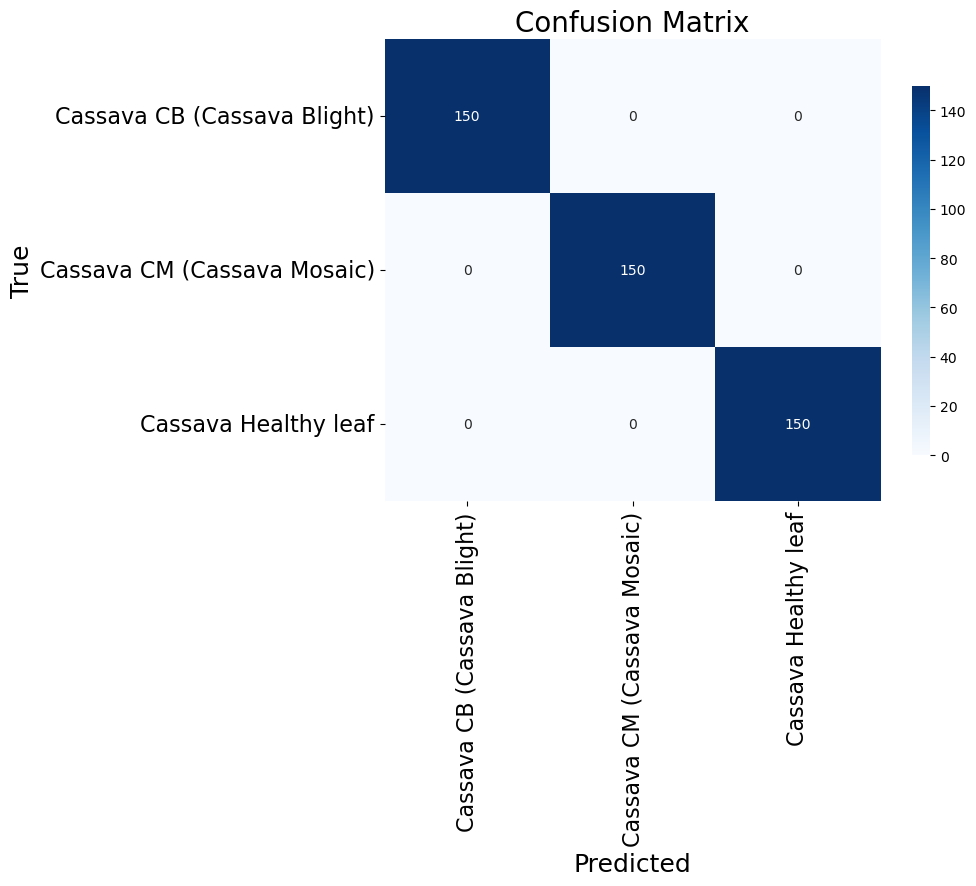

ValueError: Input contains infinity or a value too large for dtype('float32').

In [19]:
evaluate_model(model, test_loader)

In [25]:
torch.save(model.state_dict(), "Bonelcnet_100.pth")

In [20]:
import pretrainedmodels
from pretrainedmodels import utils

# Load the NASNetMobile model with pre-trained weights
model = pretrainedmodels.__dict__['nasnetamobile'](num_classes=1000, pretrained='imagenet')

# Define a Dropout layer with 0.5 probability
dropout = nn.Dropout(p=0.5)

num_classes = len(label_mapping)
# Modify the model to include the Dropout layer before the final fully connected layer
model.last_linear = nn.Sequential(
    nn.Dropout(p=0.5),  # Dropout layer with 50% probability
    nn.Linear(model.last_linear.in_features, num_classes)  # Final linear layer with the number of classes
)

model = model.to(device)

# Define the loss function, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)


Epoch 1/20
----------


Validation Loss: 0.0213, Validation Accuracy: 0.9933
Epoch 1/20, Loss: 0.1315, Accuracy: 0.9529
Epoch 2/20
----------


Validation Loss: 0.0122, Validation Accuracy: 0.9933
Epoch 2/20, Loss: 0.0796, Accuracy: 0.9788
Patience Counter: 1/5
Epoch 3/20
----------


Validation Loss: 0.0012, Validation Accuracy: 1.0000
Epoch 3/20, Loss: 0.0179, Accuracy: 0.9938
Epoch 4/20
----------


Validation Loss: 0.0002, Validation Accuracy: 1.0000
Epoch 4/20, Loss: 0.0146, Accuracy: 0.9967
Patience Counter: 1/5
Epoch 5/20
----------


Validation Loss: 0.0000, Validation Accuracy: 1.0000
Epoch 5/20, Loss: 0.0002, Accuracy: 1.0000
Patience Counter: 2/5
Epoch 6/20
----------


Validation Loss: 0.0001, Validation Accuracy: 1.0000
Epoch 6/20, Loss: 0.0004, Accuracy: 1.0000
Patience Counter: 3/5
Epoch 7/20
----------


Validation Loss: 0.0000, Validation Accuracy: 1.0000
Epoch 7/20, Loss: 0.0002, Accuracy: 1.0000
Patience Counter: 4/5
Epoch 8/20
----------


Validation Loss: 0.0000, Validation Accuracy: 1.0000
Epoch 8/20, Loss: 0.0001, Accuracy: 1.0000
Patience Counter: 5/5
Early stopping triggered at epoch 8 (Patience exceeded).


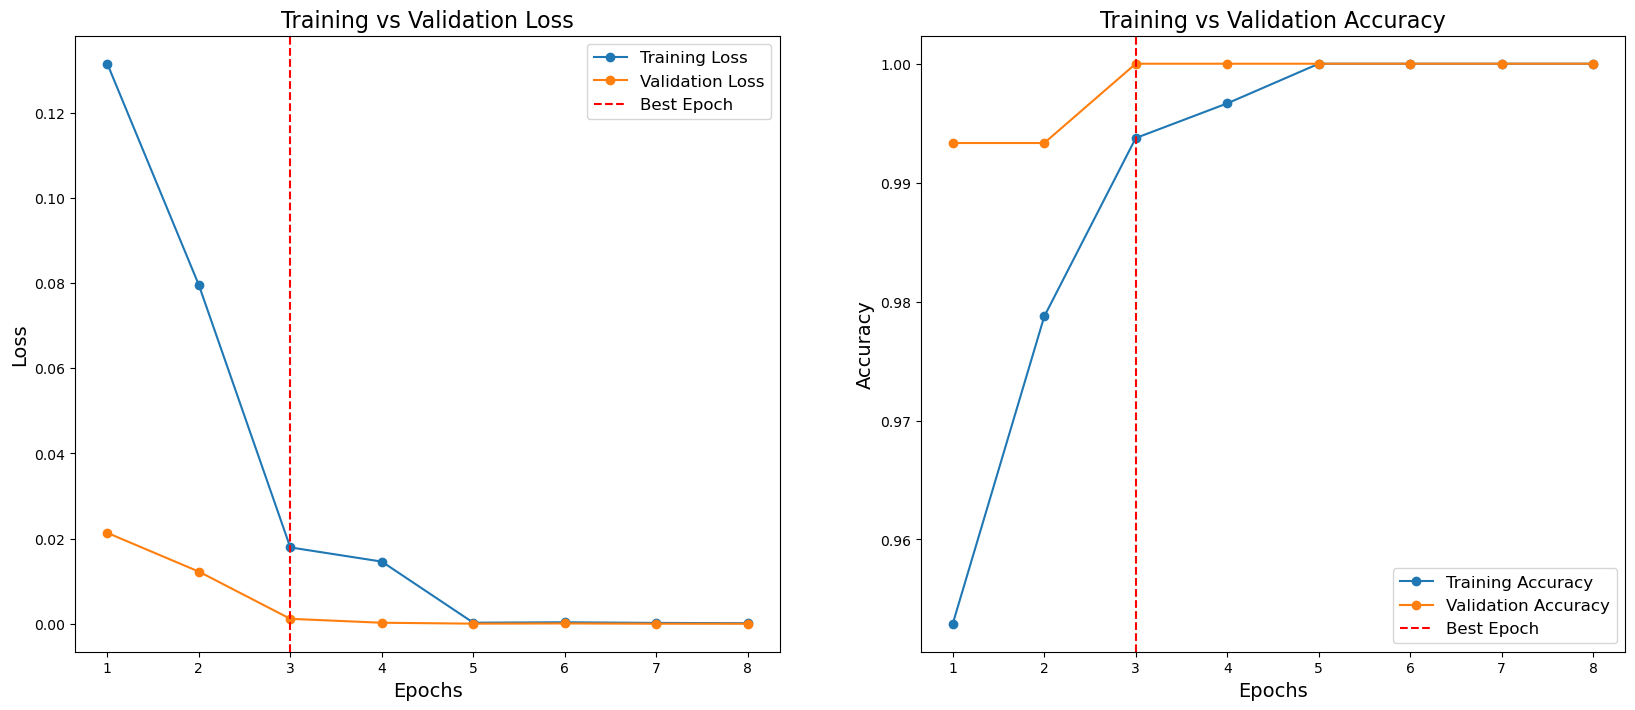


Training Report:
Total epochs run: 8
Final Training Loss: 0.0001
Final Training Accuracy: 1.0000

Validation Report:
Best Validation Loss: 0.0012 at epoch 3
Final Validation Loss: 0.0000
Final Validation Accuracy: 1.0000


In [21]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20, patience=5):
    model.train()
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    best_val_loss = float('inf')
    best_val_accuracy = 0.0
    patience_counter = 0
    best_epoch = 0
    
    for epoch in range(num_epochs):
        model.train()
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in tqdm(train_loader, desc='Training', leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_loss = val_running_loss / len(val_loader.dataset)
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
        print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')
        
        # Early stopping check based on validation loss or accuracy
        if val_loss < best_val_loss and val_acc > best_val_accuracy:
            patience_counter = 0
            best_val_loss = val_loss
            best_val_accuracy = val_acc
            best_epoch = epoch + 1
        else:
            patience_counter += 1
            print(f"Patience Counter: {patience_counter}/{patience}")
        
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1} (Patience exceeded).")
            break
        
        # Scheduler step
        scheduler.step()
    
    total_epochs_run = epoch + 1

    # Plotting learning curves
    epochs_range = range(1, total_epochs_run + 1)
    plt.figure(figsize=(20, 8))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, marker='o', label='Training Loss')
    plt.plot(epochs_range, val_losses, marker='o', label='Validation Loss')
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.title('Training vs Validation Loss', fontsize=16)
    plt.axvline(x=best_epoch, color='red', linestyle='--', label='Best Epoch')
    plt.legend(fontsize=12)
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accuracies, marker='o', label='Training Accuracy')
    plt.plot(epochs_range, val_accuracies, marker='o', label='Validation Accuracy')
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.title('Training vs Validation Accuracy', fontsize=16)
    plt.axvline(x=best_epoch, color='red', linestyle='--', label='Best Epoch')
    plt.legend(fontsize=12)
    plt.show()

    print("\nTraining Report:")
    print(f"Total epochs run: {total_epochs_run}")
    print(f"Final Training Loss: {train_losses[-1]:.4f}")
    print(f"Final Training Accuracy: {train_accuracies[-1]:.4f}")
    
    print("\nValidation Report:")
    print(f"Best Validation Loss: {best_val_loss:.4f} at epoch {best_epoch}")
    print(f"Final Validation Loss: {val_losses[-1]:.4f}")
    print(f"Final Validation Accuracy: {val_accuracies[-1]:.4f}")


# Assume train_loader and val_loader are already defined, and model is initialized
train_model(model, train_loader, val_loader, nn.CrossEntropyLoss(), optimizer, scheduler, num_epochs=20, patience=5)

Accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       150
           1       1.00      1.00      1.00       150
           2       1.00      1.00      1.00       150

    accuracy                           1.00       450
   macro avg       1.00      1.00      1.00       450
weighted avg       1.00      1.00      1.00       450



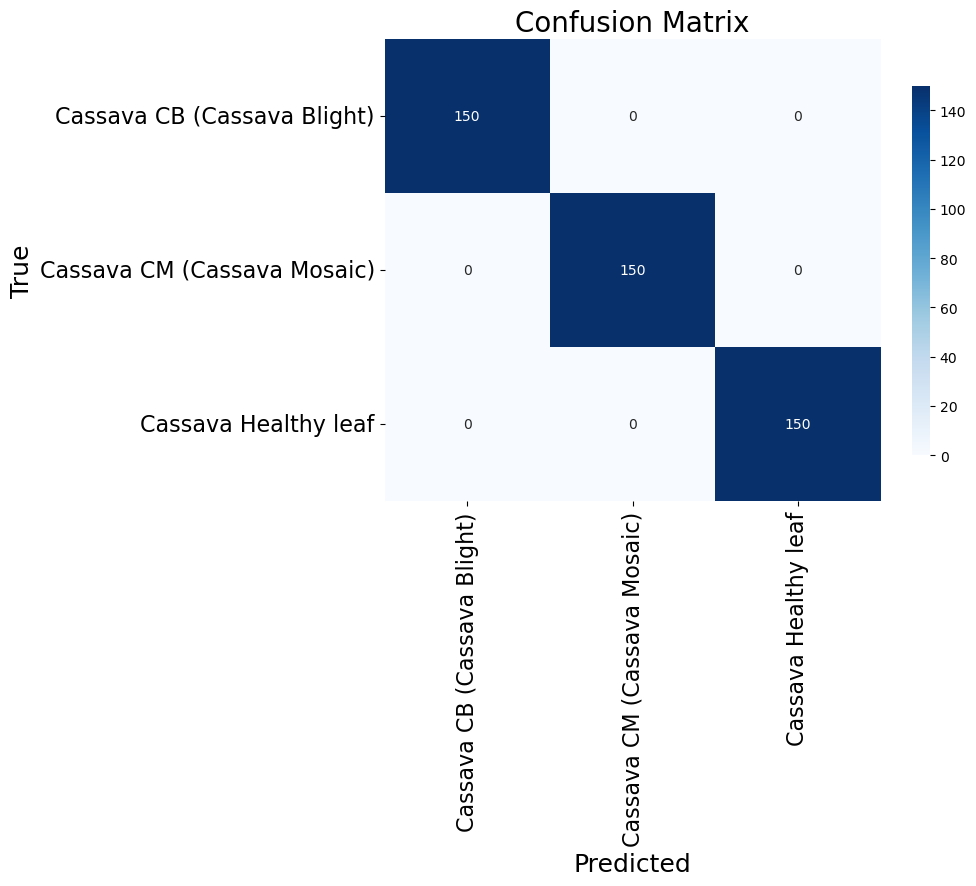

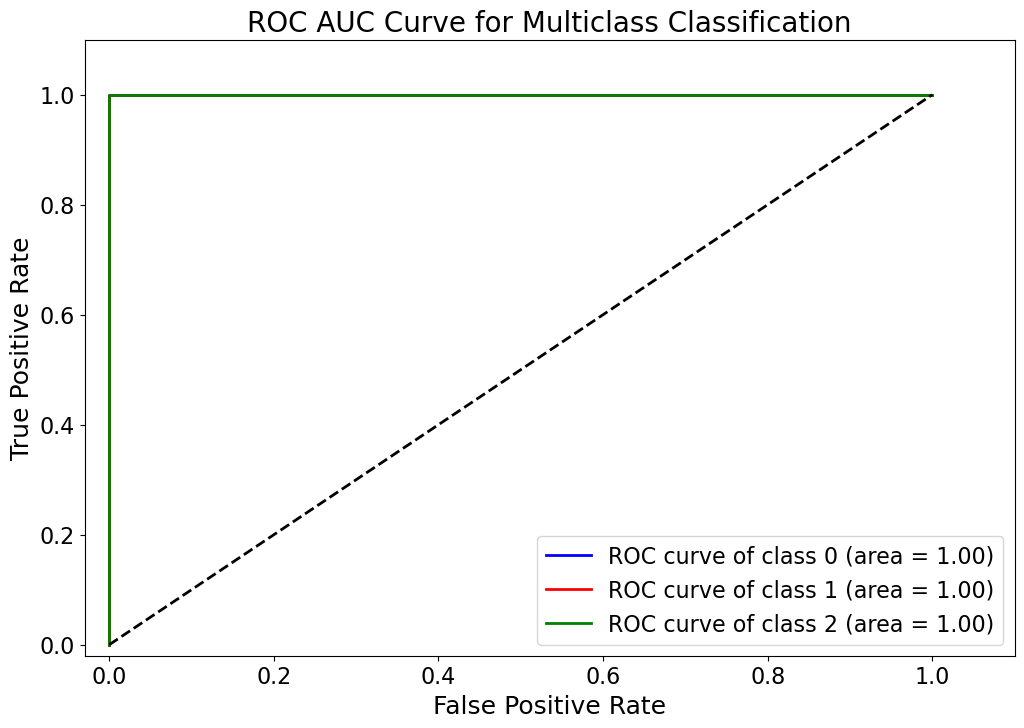

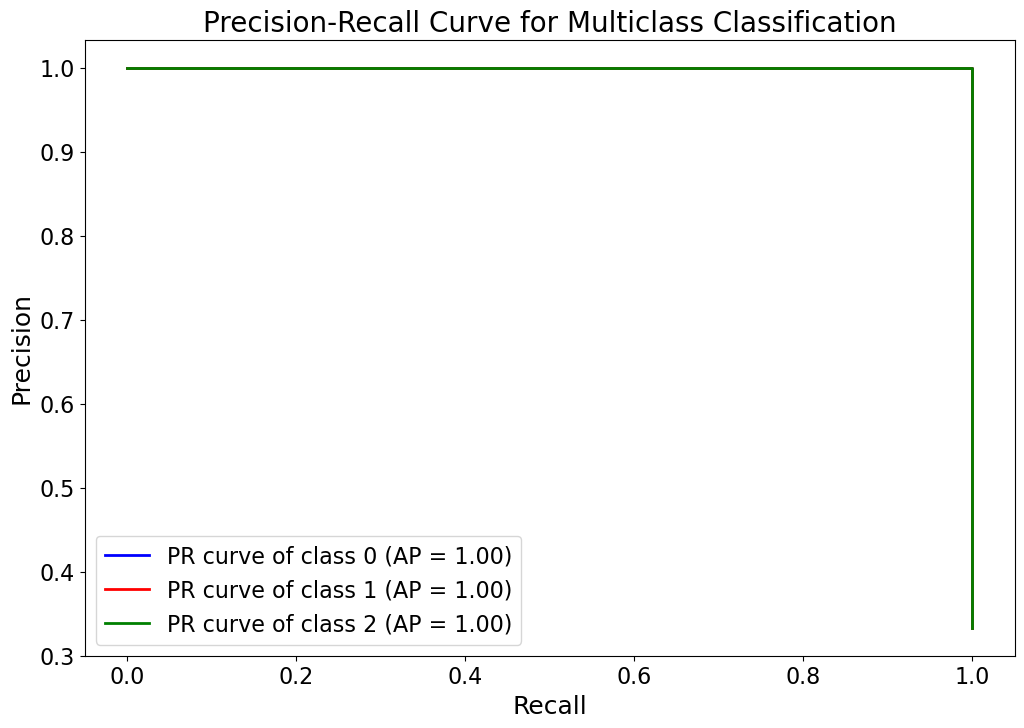

In [22]:
evaluate_model(model, test_loader)

In [20]:
torch.save(model.state_dict(), "BoneNasnet_mobile.pth")

In [12]:
import timm

# Function to load and modify the model using the timm library
def load_model(model_name, num_classes, pretrained=True):
    model = timm.create_model(model_name, pretrained=pretrained)
    
    # Modify the classifier part of the model to match the number of classes
    model.classifier = nn.Sequential(
        nn.Linear(model.classifier.in_features, 512),
        nn.ReLU(),
        nn.Dropout(0.5),  # Increased dropout rate
        nn.Linear(512, num_classes),
        nn.LogSoftmax(dim=1)
    )

    return model

# Number of classes (adjust to your problem)
num_classes = len(label_mapping)  # Replace label_mapping with the actual class labels

# Load DenseNet-201 with pre-trained weights
model = load_model("densenet201", num_classes, pretrained=True)

model = model.to(device)

# Loss function and optimizer (AdamW with weight decay)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)


Epoch 1/20
------------------------------


Validation Loss: 0.0223, Validation Accuracy: 0.9933
Training Loss: 0.2552, Training Accuracy: 0.9258

Epoch 2/20
------------------------------


Validation Loss: 0.3943, Validation Accuracy: 0.8733
Training Loss: 0.1579, Training Accuracy: 0.9613
Patience Counter: 1/5

Epoch 3/20
------------------------------


Validation Loss: 0.0378, Validation Accuracy: 0.9867
Training Loss: 0.0842, Training Accuracy: 0.9729
Patience Counter: 2/5

Epoch 4/20
------------------------------


Validation Loss: 0.0190, Validation Accuracy: 0.9933
Training Loss: 0.1031, Training Accuracy: 0.9738

Epoch 5/20
------------------------------


Validation Loss: 0.0036, Validation Accuracy: 1.0000
Training Loss: 0.0242, Training Accuracy: 0.9912

Epoch 6/20
------------------------------


Validation Loss: 0.0018, Validation Accuracy: 1.0000
Training Loss: 0.0207, Training Accuracy: 0.9954

Epoch 7/20
------------------------------


Validation Loss: 0.0055, Validation Accuracy: 1.0000
Training Loss: 0.0286, Training Accuracy: 0.9896
Patience Counter: 1/5

Epoch 8/20
------------------------------


Validation Loss: 0.0049, Validation Accuracy: 1.0000
Training Loss: 0.0523, Training Accuracy: 0.9946
Patience Counter: 2/5

Epoch 9/20
------------------------------


Validation Loss: 0.0012, Validation Accuracy: 1.0000
Training Loss: 0.0115, Training Accuracy: 0.9983
Patience Counter: 3/5

Epoch 10/20
------------------------------


Validation Loss: 0.0010, Validation Accuracy: 1.0000
Training Loss: 0.0102, Training Accuracy: 0.9975
Patience Counter: 4/5

Epoch 11/20
------------------------------


Validation Loss: 0.0009, Validation Accuracy: 1.0000
Training Loss: 0.0086, Training Accuracy: 0.9992
Patience Counter: 5/5
Early stopping triggered at epoch 11.


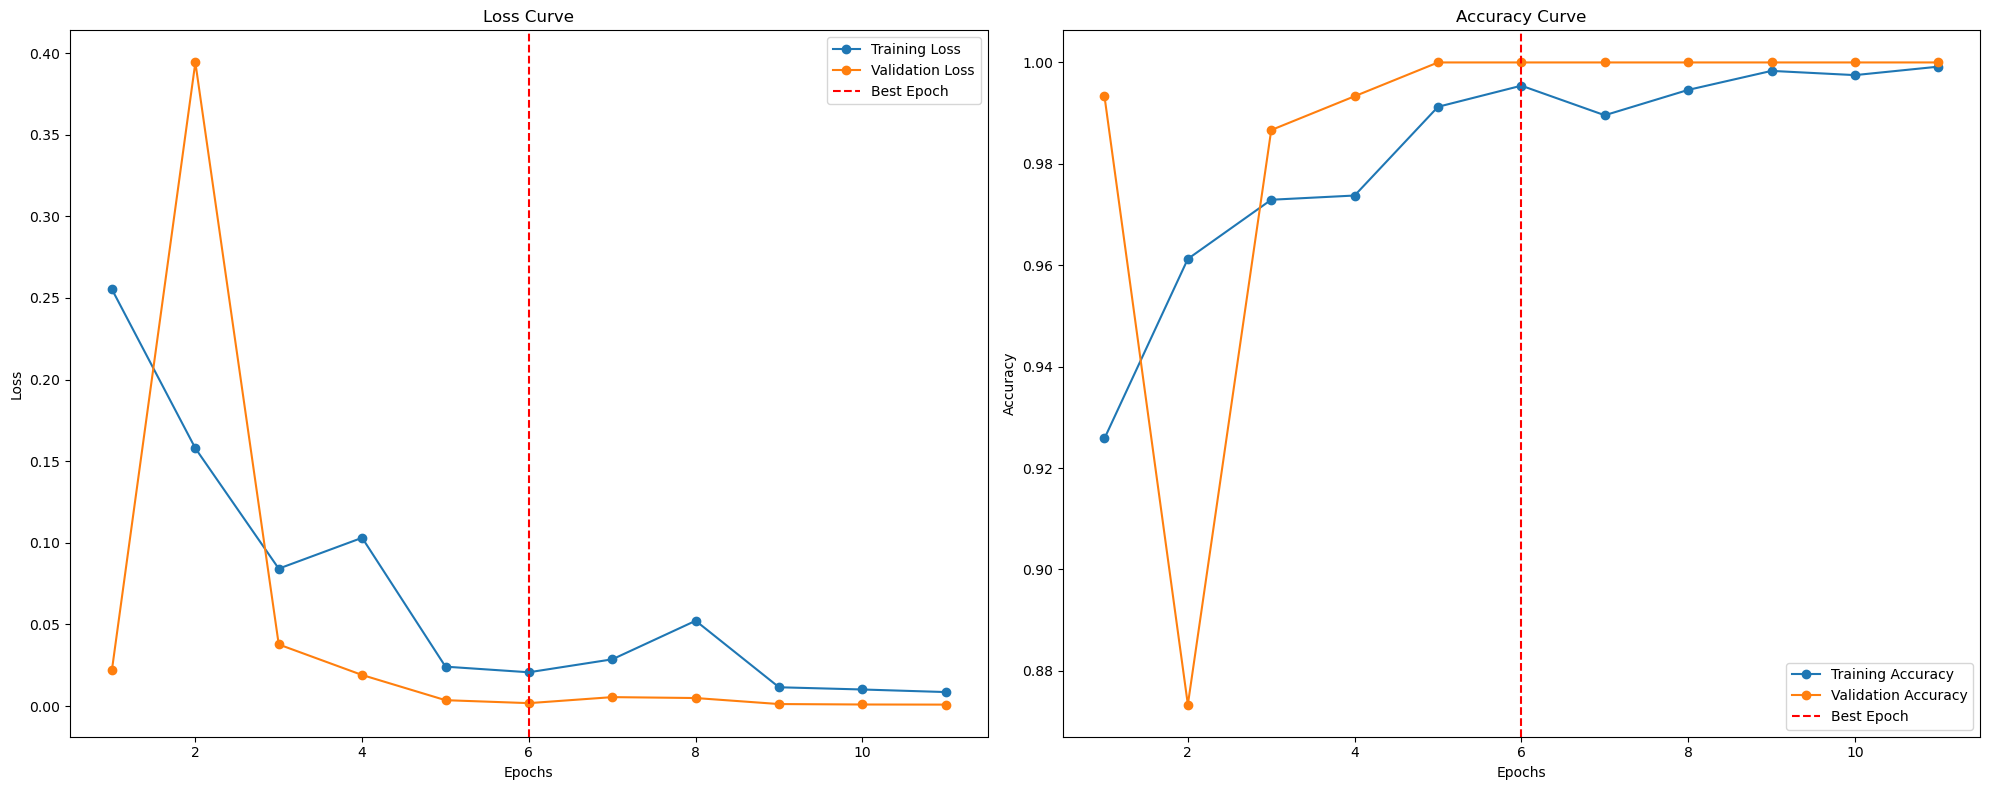


Training Report:
Total epochs run: 11
Best Training Loss: 0.0207 at epoch 6
Best Training Accuracy: 0.9954

Validation Report:
Best Validation Loss: 0.0018 at epoch 6
Best Validation Accuracy: 1.0000
Final Validation Loss: 0.0009
Final Validation Accuracy: 1.0000


In [13]:
from torch.cuda.amp import autocast, GradScaler

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20, patience=5, min_delta=0.001):
    model.to(device)
    scaler = GradScaler()  # AMP gradient scaler
    
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []
    
    best_val_loss = float('inf')
    patience_counter = 0
    best_epoch = 0
    
    for epoch in range(num_epochs):
        model.train()
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 30)
        running_loss = 0.0
        correct = 0
        total = 0

        # Training loop with AMP
        for inputs, labels in tqdm(train_loader, desc='Training', leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            
            with autocast():  # Forward pass in mixed precision
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        # Validation loop with AMP (inference only)
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                with autocast():
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                
                val_running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(val_loader.dataset)
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')
        print(f'Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_acc:.4f}')
        
        # Early Stopping
        if best_val_loss - val_loss > min_delta:
            best_val_loss = val_loss
            best_epoch = epoch + 1
            patience_counter = 0
        else:
            patience_counter += 1
            print(f"Patience Counter: {patience_counter}/{patience}")
        
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}.")
            break
        
        scheduler.step()

    total_epochs_run = epoch + 1
    epochs_range = range(1, total_epochs_run + 1)

    # Plotting curves
    plt.figure(figsize=(20, 8))
    
    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, marker='o', label='Training Loss')
    plt.plot(epochs_range, val_losses, marker='o', label='Validation Loss')
    plt.axvline(x=best_epoch, color='red', linestyle='--', label='Best Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()
    
    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accuracies, marker='o', label='Training Accuracy')
    plt.plot(epochs_range, val_accuracies, marker='o', label='Validation Accuracy')
    plt.axvline(x=best_epoch, color='red', linestyle='--', label='Best Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

    # Reports
    print("\nTraining Report:")
    print(f"Total epochs run: {total_epochs_run}")
    print(f"Best Training Loss: {train_losses[best_epoch-1]:.4f} at epoch {best_epoch}")
    print(f"Best Training Accuracy: {train_accuracies[best_epoch-1]:.4f}")
    
    print("\nValidation Report:")
    print(f"Best Validation Loss: {best_val_loss:.4f} at epoch {best_epoch}")
    print(f"Best Validation Accuracy: {val_accuracies[best_epoch-1]:.4f}")
    print(f"Final Validation Loss: {val_losses[-1]:.4f}")
    print(f"Final Validation Accuracy: {val_accuracies[-1]:.4f}")


train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20, patience=5, min_delta=0.001)

In [14]:
def evaluate_model(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    all_probs = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            
            # Convert LogSoftmax to probabilities
            probs = torch.exp(outputs)  # Exponentiate to get probabilities
            
            # Get the predicted class (highest probability)
            _, predicted = torch.max(outputs, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Collect all labels, predictions, and probabilities for further analysis
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    accuracy = correct / total
    print(f'Accuracy: {accuracy:.4f}')
    print(classification_report(all_labels, all_preds))
    
    # ------------------------------
    # Plot Confusion Matrix
    # ------------------------------
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys(),
                cbar_kws={'shrink': 0.8})
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16, rotation=0)
    plt.xlabel('Predicted', fontsize=18)
    plt.ylabel('True', fontsize=18)
    plt.title('Confusion Matrix', fontsize=20)
    plt.show()

    # ------------------------------
    # Plot ROC AUC curves
    # ------------------------------
    n_classes = len(label_mapping)
    y_test_bin = label_binarize(all_labels, classes=range(n_classes))

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], np.array(all_probs)[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    plt.figure(figsize=(12, 8))
    colors = cycle(['blue', 'red', 'green', 'orange'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of class {i} (area = {roc_auc[i]:0.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([-0.03, 1.1])
    plt.ylim([-0.02, 1.1])
    plt.xlabel('False Positive Rate', fontsize=18)
    plt.ylabel('True Positive Rate', fontsize=18)
    plt.title('ROC AUC Curve for Multiclass Classification', fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(fontsize=16)
    plt.show()

    # ------------------------------
    # Plot Precision-Recall curves
    # ------------------------------
    precision = dict()
    recall = dict()
    average_precision = dict()
    
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], np.array(all_probs)[:, i])
        average_precision[i] = average_precision_score(y_test_bin[:, i], np.array(all_probs)[:, i])
    
    plt.figure(figsize=(12, 8))
    for i, color in zip(range(n_classes), cycle(['blue', 'red', 'green', 'orange'])):
        plt.plot(recall[i], precision[i], color=color, lw=2,
                 label=f'PR curve of class {i} (AP = {average_precision[i]:0.2f})')
    plt.xlabel('Recall', fontsize=18)
    plt.ylabel('Precision', fontsize=18)
    plt.title('Precision-Recall Curve for Multiclass Classification', fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(fontsize=16)
    plt.show()

Accuracy: 0.9978
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       150
           1       1.00      1.00      1.00       150
           2       1.00      0.99      1.00       150

    accuracy                           1.00       450
   macro avg       1.00      1.00      1.00       450
weighted avg       1.00      1.00      1.00       450



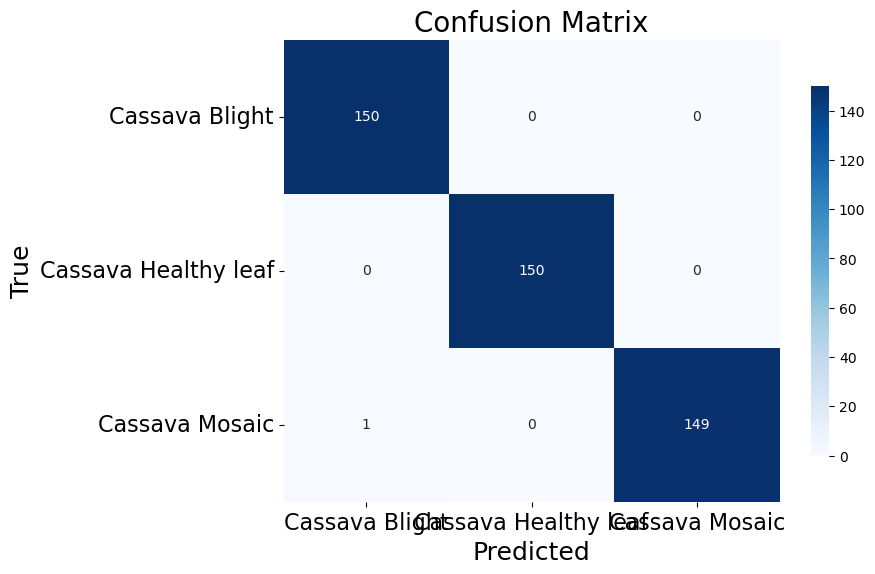

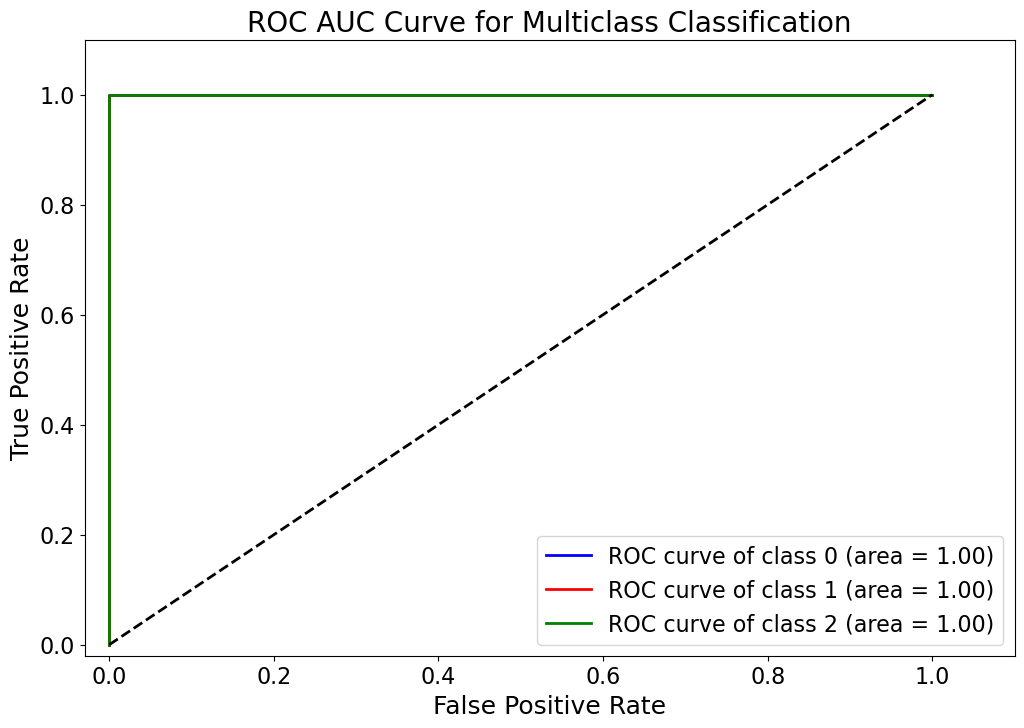

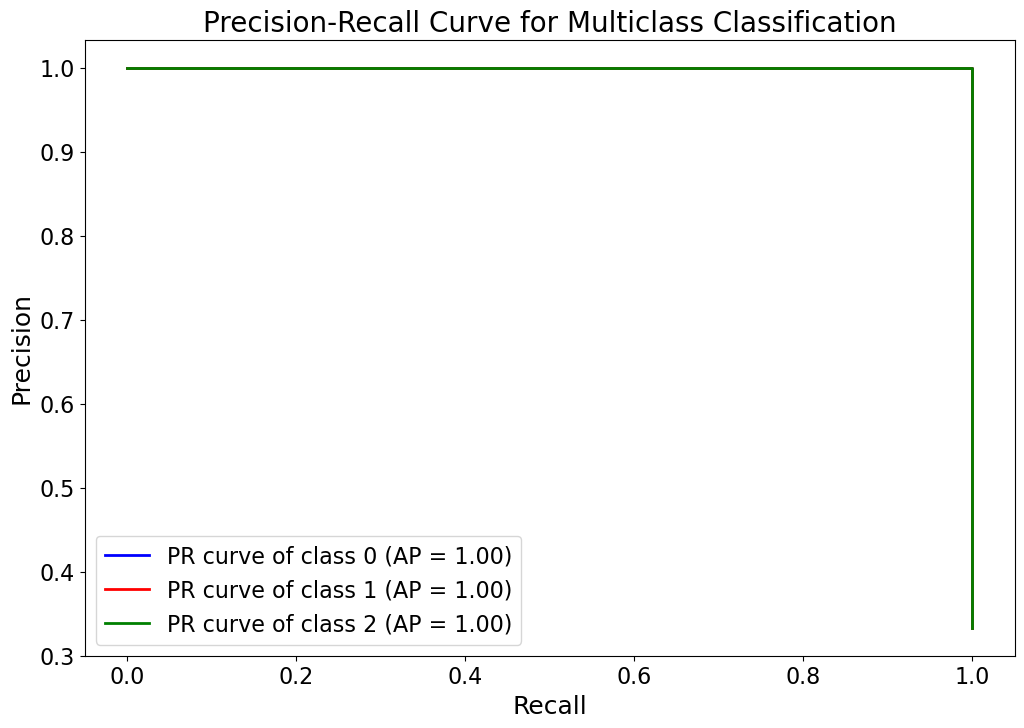

In [17]:
evaluate_model(model, test_loader)

In [16]:
torch.save(model.state_dict(), "BoneDenseNet-201.pth")

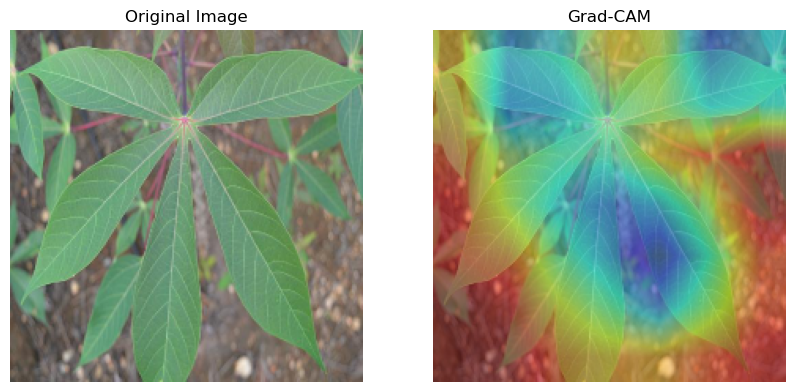

In [18]:
import torch
import torch.nn.functional as F
import cv2
import matplotlib.pyplot as plt
import numpy as np
from torchvision import models

# Grad-CAM implementation
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Hook to save gradients
        def save_gradients(module, grad_input, grad_output):
            self.gradients = grad_output[0]

        # Hook to save activations
        def save_activations(module, input, output):
            self.activations = output

        self.target_layer.register_backward_hook(save_gradients)
        self.target_layer.register_forward_hook(save_activations)

    def generate_heatmap(self, input_tensor, target_class):
        self.model.eval()
        output = self.model(input_tensor)
        self.model.zero_grad()
        class_score = output[:, target_class]
        class_score.backward()

        # Get gradients and activations
        gradients = self.gradients.detach()
        activations = self.activations.detach()

        # Global average pooling of gradients
        weights = torch.mean(gradients, dim=[2, 3], keepdim=True)
        heatmap = torch.sum(weights * activations, dim=1).squeeze()
        heatmap = torch.relu(heatmap)
        heatmap /= torch.max(heatmap)
        return heatmap.cpu().numpy()

# Example usage of Grad-CAM
def visualize_gradcam(image_path, model, target_layer, target_class):
    # Load and preprocess the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    original_image = cv2.resize(image, (224, 224))
    transformed_image = data_transform(original_image).unsqueeze(0).to(device)

    # Initialize Grad-CAM
    grad_cam = GradCAM(model, target_layer)

    # Generate heatmap
    heatmap = grad_cam.generate_heatmap(transformed_image, target_class)

    # Resize heatmap to match the original image size
    heatmap_resized = cv2.resize(heatmap, (original_image.shape[1], original_image.shape[0]))
    heatmap_colored = cv2.applyColorMap((heatmap_resized * 255).astype(np.uint8), cv2.COLORMAP_JET)

    # Overlay heatmap on the original image
    overlay = cv2.addWeighted(original_image, 0.6, heatmap_colored, 0.4, 0)

    # Plot results
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(original_image)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Grad-CAM")
    plt.imshow(overlay)
    plt.axis('off')
    plt.show()

# Select an image and visualize Grad-CAM
sample_image_path = test_df['filepaths'].values[0]  # Example from test set
sample_class = test_labels[0]  # Corresponding class
visualize_gradcam(sample_image_path, model, model.features[-1], sample_class)


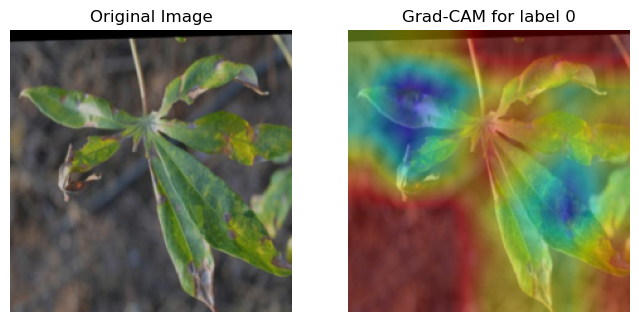

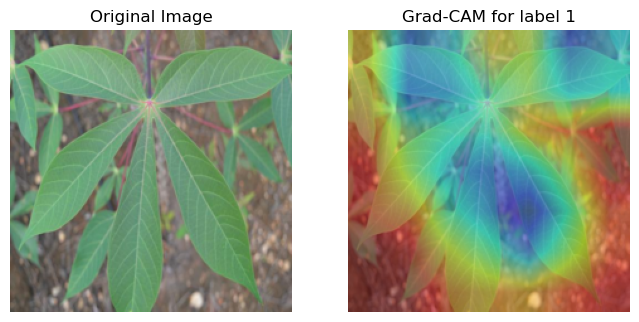

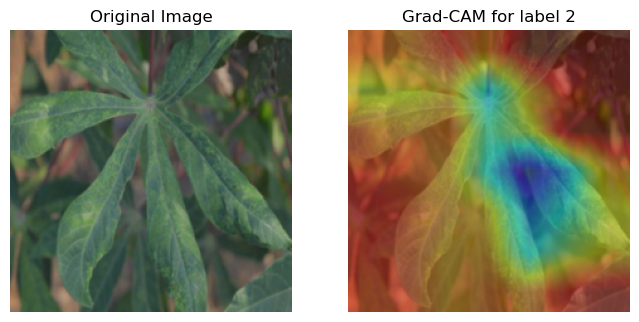

In [19]:
def generate_gradcam_per_label(model, dataloader, target_layer, label_mapping):
    grad_cam = GradCAM(model, target_layer)

    correct_samples = {label: None for label in label_mapping.values()}

    # Find one correctly classified image per label
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        for i in range(inputs.size(0)):
            label = labels[i].item()
            if preds[i].item() == label and correct_samples[label] is None:
                correct_samples[label] = (inputs[i].unsqueeze(0), label)

        if all(v is not None for v in correct_samples.values()):
            break

    # Generate Grad-CAM visualizations
    for label, (input_tensor, label_idx) in correct_samples.items():
        if input_tensor is not None:
            heatmap = grad_cam.generate_heatmap(input_tensor, label_idx)

            # Convert heatmap to overlay
            original_image = (
                input_tensor.squeeze().permute(1, 2, 0).detach().cpu().numpy() * np.array([0.229, 0.224, 0.225]) +
                np.array([0.485, 0.456, 0.406])
            ) * 255
            original_image = original_image.astype(np.uint8)
            heatmap_resized = cv2.resize(heatmap, (original_image.shape[1], original_image.shape[0]))
            heatmap_colored = cv2.applyColorMap((heatmap_resized * 255).astype(np.uint8), cv2.COLORMAP_JET)
            overlay = cv2.addWeighted(original_image, 0.6, heatmap_colored, 0.4, 0)

            # Plot results
            plt.figure(figsize=(8, 4))
            plt.subplot(1, 2, 1)
            plt.title("Original Image")
            plt.imshow(original_image)
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.title(f"Grad-CAM for label {label}")
            plt.imshow(overlay)
            plt.axis('off')
            plt.show()

# Generate Grad-CAM visualizations for each label
generate_gradcam_per_label(model, test_loader, model.features[-1], label_mapping)

In [16]:
import timm
# Function to load and modify the model
def load_model(model_name, num_classes, pretrained=True):
    model = timm.create_model(model_name, pretrained=pretrained)
    
    # Modify the classifier part of the model to match the number of classes
    model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, 512),
        nn.ReLU(),
        nn.Dropout(0.5),  # Increased dropout rate
        nn.Linear(512, num_classes),
        nn.LogSoftmax(dim=1)
    )

    return model

# Number of classes (adjust to your problem)
num_classes = len(label_mapping)  # Replace label_mapping with the actual class labels

# Load ResNeXt101 with pre-trained weights
model = load_model("resnext101_32x8d", num_classes, pretrained=True)

model = model.to(device)

# Loss function and optimizer (AdamW with weight decay)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)

In [14]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20, patience=5):
    model.train()
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    best_val_loss = float('inf')
    best_val_accuracy = 0.0
    patience_counter = 0
    best_epoch = 0
    
    for epoch in range(num_epochs):
        model.train()
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in tqdm(train_loader, desc='Training', leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_loss = val_running_loss / len(val_loader.dataset)
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
        print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')
        
        # Early stopping check based on validation loss or accuracy
        if val_loss < best_val_loss and val_acc > best_val_accuracy:
            # Reset the patience counter if there is an improvement
            patience_counter = 0
            best_val_loss = val_loss
            best_val_accuracy = val_acc
            best_epoch = epoch + 1
        else:
            patience_counter += 1
            print(f"Patience Counter: {patience_counter}/{patience}")
        
        # If the patience counter reaches the patience limit, stop training
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1} (Patience exceeded).")
            break
        
        # Step the scheduler at the end of each epoch
        scheduler.step()
    
    total_epochs_run = epoch + 1

    # Plot learning curves with early stopping marker at the best epoch
    epochs_range = range(1, total_epochs_run + 1)
    plt.figure(figsize=(20, 8))
    
    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, marker='o', label='Training Loss')
    plt.plot(epochs_range, val_losses, marker='o', label='Validation Loss')
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.title('Training vs Validation Loss', fontsize=16)
    plt.axvline(x=best_epoch, color='red', linestyle='--', label='Best Epoch')
    plt.legend(fontsize=12)
    
    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accuracies, marker='o', label='Training Accuracy')
    plt.plot(epochs_range, val_accuracies, marker='o', label='Validation Accuracy')
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.title('Training vs Validation Accuracy', fontsize=16)
    plt.axvline(x=best_epoch, color='red', linestyle='--', label='Best Epoch')
    plt.legend(fontsize=12)
    plt.show()

    # Print training and validation reports
    print("\nTraining Report:")
    print("-----------------")
    print(f"Total epochs run: {total_epochs_run}")
    print(f"Final Training Loss: {train_losses[-1]:.4f}")
    print(f"Final Training Accuracy: {train_accuracies[-1]:.4f}")
    
    print("\nValidation Report:")
    print("-----------------")
    print(f"Best Validation Loss: {best_val_loss:.4f} at epoch {best_epoch}")
    print(f"Final Validation Loss: {val_losses[-1]:.4f}")
    print(f"Final Validation Accuracy: {val_accuracies[-1]:.4f}")


train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20, patience=5)


Epoch 1/20
----------


KeyboardInterrupt: 

Accuracy: 0.9933
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       150
           1       1.00      0.98      0.99       150
           2       1.00      1.00      1.00       150

    accuracy                           0.99       450
   macro avg       0.99      0.99      0.99       450
weighted avg       0.99      0.99      0.99       450



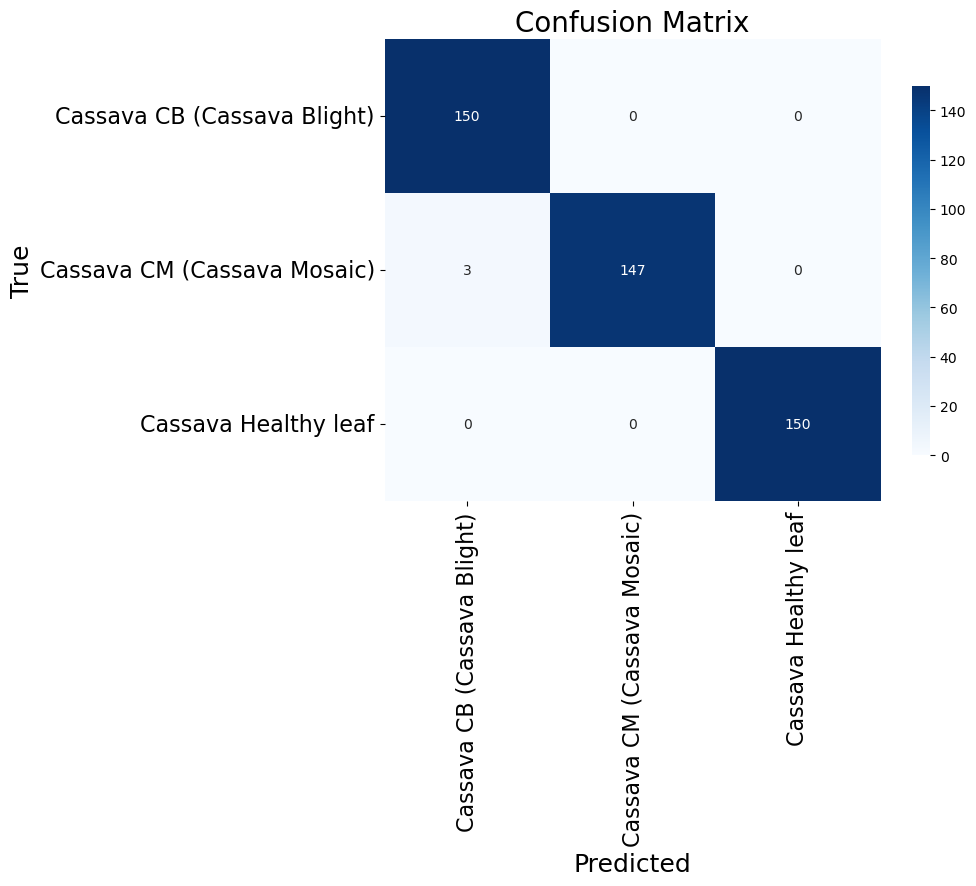

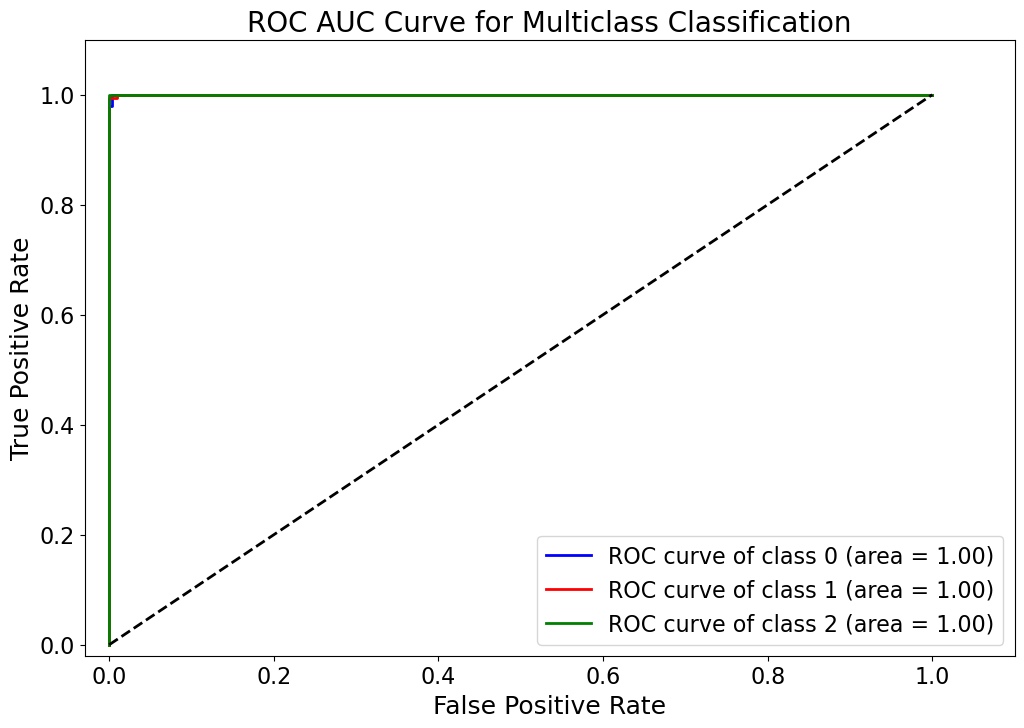

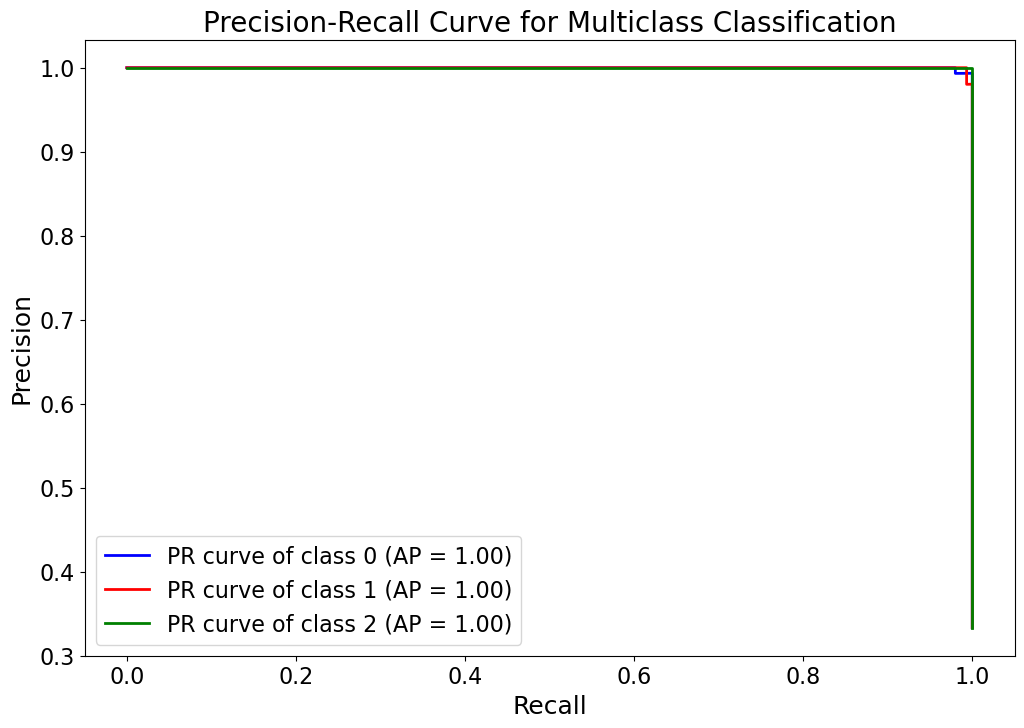

In [18]:
evaluate_model(model, test_loader)

In [16]:
torch.save(model.state_dict(), "BoneResNeXt-101.pth")